https://data.sdss.org/sas/apogeework/apogee/spectro/aspcap/r13/l33/lco25m/JHelum1/
and etc for 2, 3, 4...

In [1]:
import glob
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

coord.galactocentric_frame_defaults.set('v4.0')

import gala.coordinates as gc

In [33]:
# jhelum_frame = gc.JhelumBonaca19()

# From Shipp et al. 2018
c1 = coord.SkyCoord(ra=-38.8*u.deg, dec=-45.1*u.deg)
c2 = coord.SkyCoord(ra=4.7*u.deg, dec=-51.7*u.deg)
jhelum_frame = gc.GreatCircleICRSFrame.from_endpoints(c1, c2)

In [35]:
cand_tbl = at.Table.read('../data/jhelum_candidates.csv')
cand_c = coord.SkyCoord(ra=cand_tbl['ra']*u.deg,
                        dec=cand_tbl['dec']*u.deg,
                        pm_ra_cosdec=cand_tbl['pmra']*u.mas/u.yr,
                        pm_dec=cand_tbl['pmdec']*u.mas/u.yr)
cand_jc = cand_c.transform_to(jhelum_frame)

In [3]:
keep_cols = ['FIELD', 'APOGEE_ID', 'RA', 'DEC', 'J', 'H', 'K', 
             'SNR', 'VHELIO', 'VERR',
             'PARAM', 'PARAM_COV', 'ELEM', 'ELEM_ERR']

tbls = []
for filename in sorted(glob.glob('../data/aspcapField-JHelum*.fits')):
    tbls.append(at.Table.read(filename)[keep_cols])

In [4]:
# at.Table.read(filename).colnames

In [38]:
tbl = at.vstack(tbls)

c = coord.SkyCoord(ra=tbl['RA']*u.deg,
                   dec=tbl['DEC']*u.deg,
                   radial_velocity=tbl['VHELIO']*u.km/u.s)
j_c = c.transform_to(jhelum_frame)

In [16]:
tbl.write('../data/jhelum-apogee-all.fits')

In [56]:
idx, sep, _ = coord.match_coordinates_sky(c, cand_c)

stream_mask = sep < 2*u.arcsec

stream_tbl = tbl[stream_mask]
stream_tbl = at.hstack((stream_tbl, cand_tbl[idx[stream_mask]]))

stream_c = coord.SkyCoord(ra=stream_tbl['RA']*u.deg,
                          dec=stream_tbl['DEC']*u.deg,
                          distance=13*u.kpc,
                          radial_velocity=stream_tbl['VHELIO']*u.km/u.s,
                          pm_ra_cosdec=stream_tbl['pmra']*u.mas/u.yr,
                          pm_dec=stream_tbl['pmdec']*u.mas/u.yr)
stream_jc = stream_c.transform_to(jhelum_frame)
stream_jc_reflex = gc.reflex_correct(stream_jc, galactocentric_frame=coord.Galactocentric())


_mask = (stream_jc.pm_phi1_cosphi2 < 10*u.mas/u.yr)
stream_tbl = stream_tbl[_mask]
stream_jc = stream_jc[_mask]
stream_jc_reflex = stream_jc_reflex[_mask]

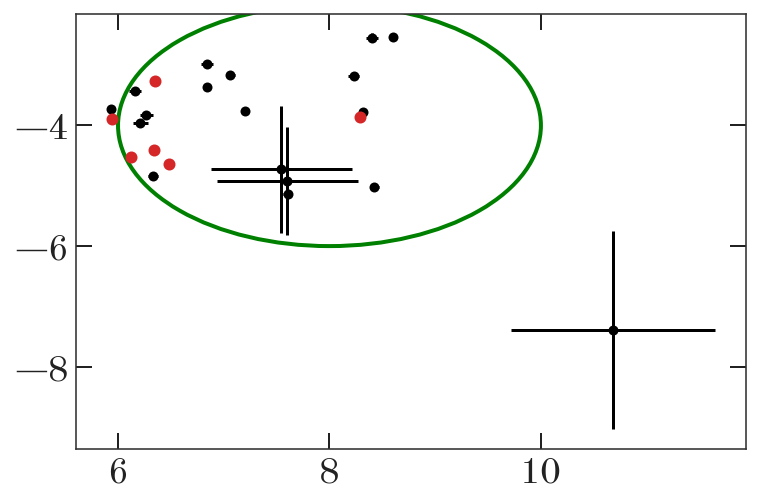

In [57]:
plt.errorbar(cand_jc.pm_phi1_cosphi2.value, 
             cand_jc.pm_phi2.value,
             xerr=cand_tbl['pmra_error'],
             yerr=cand_tbl['pmdec_error'],
             marker='o', ls='none')

plt.scatter(stream_jc.pm_phi1_cosphi2,
            stream_jc.pm_phi2, 
            marker='o', color='tab:red', zorder=100)

pmxy0 = [8., -4.]
pmr = 2.
circ = mpl.patches.Circle(pmxy0, pmr,
                          facecolor='none', linewidth=2, 
                          edgecolor='green')
plt.gca().add_patch(circ)

PARAM: Teff, log g, vmicro, [M/H], [C/M], [N/M], [α/M], vsini/vmacro]

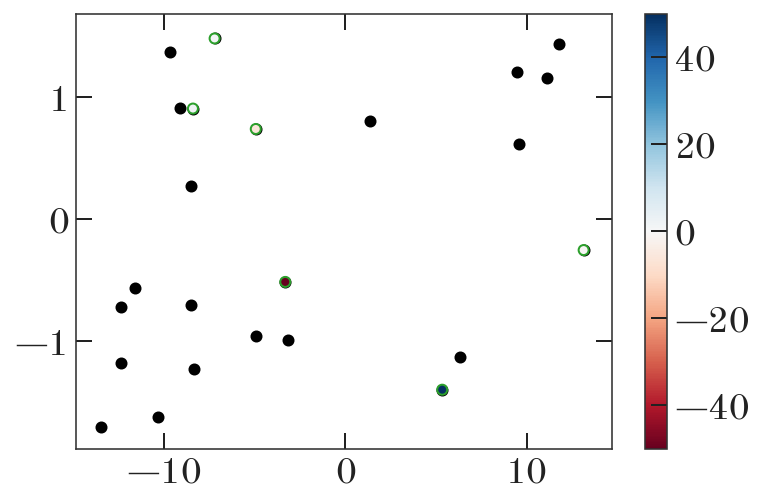

In [59]:
plt.scatter(cand_jc.phi1.degree, cand_jc.phi2.degree, 
            zorder=-10, color='k')
plt.scatter(stream_jc.phi1.degree, 
            stream_jc.phi2.degree,
            c=stream_tbl['VHELIO'], 
            vmin=-50, vmax=50, cmap='RdBu', 
            linewidth=1, edgecolor='tab:green')
plt.colorbar()

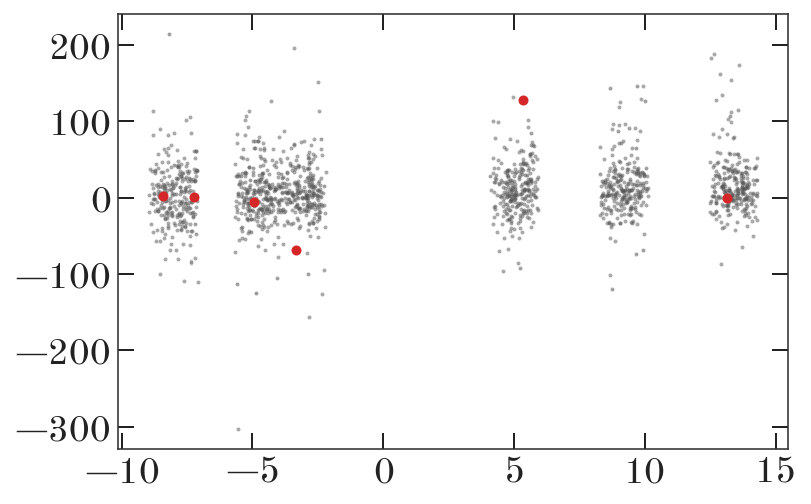

In [60]:
plt.errorbar(j_c.phi1.degree, tbl['VHELIO'], yerr=tbl['VERR'],
             ls='none', marker='o', 
             color='#555555', ecolor='#aaaaaa', 
             alpha=0.5, mew=0, ms=2)

plt.scatter(stream_jc.phi1.degree,
            stream_tbl['VHELIO'],
            marker='o', color='tab:red', 
            s=16, zorder=100)

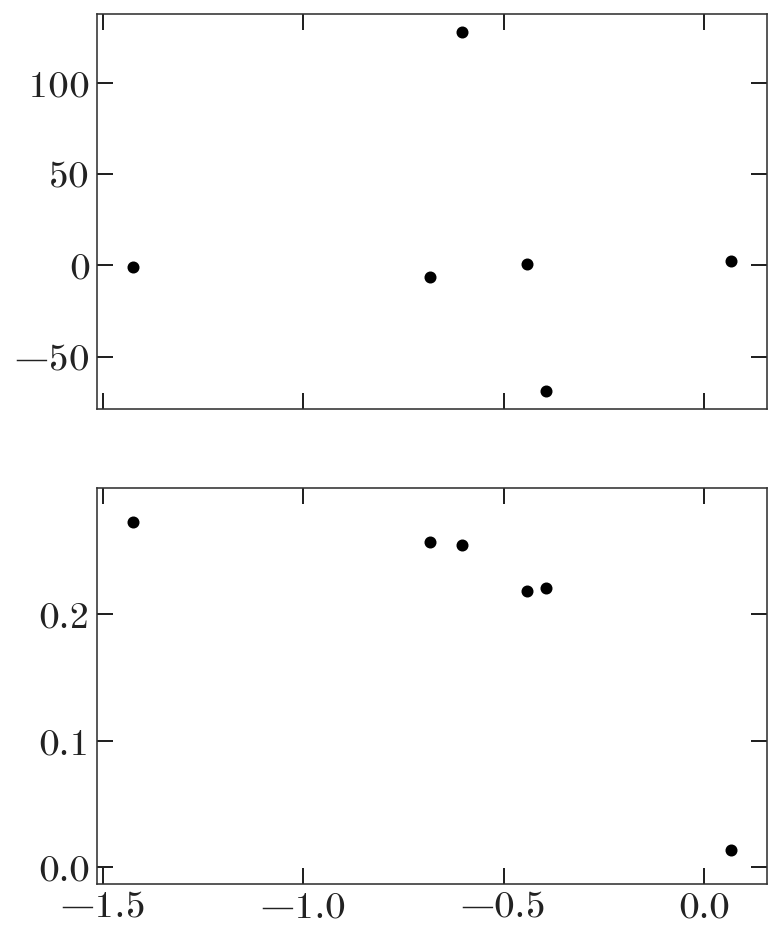

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

ax = axes[0]
ax.scatter(stream_tbl['PARAM'][:, 3], stream_tbl['VHELIO'])

ax = axes[1]
ax.scatter(stream_tbl['PARAM'][:, 3], stream_tbl['PARAM'][:, 6])